# initialization

In [1]:
import numpy as np
import tensorflow as tf

np.random.seed(1793)
tf.random.set_seed(1793)

# Problem definition : Branin

In [2]:
from trieste.objectives import (
    scaled_branin,
    SCALED_BRANIN_MINIMUM,
    BRANIN_SEARCH_SPACE,
)
from trieste.objectives.utils import mk_observer
from trieste.space import Box

search_space = Box([0, 0], [1, 1])

2022-05-12 12:53:10.776959: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Design of Experiment

In [3]:
import trieste

observer = trieste.objectives.utils.mk_observer(scaled_branin)

num_initial_points = 8
initial_query_points = search_space.sample_sobol(num_initial_points)
initial_data = observer(initial_query_points)

In [4]:
print(f"DoE points: \n {initial_query_points[:, :]}")
print(f"DoE values: \n {initial_data.observations[:]}")

DoE points: 
 [[0.75563049 0.81419373]
 [0.50563049 0.06419373]
 [0.00563049 0.56419373]
 [0.00758362 0.06614685]
 [0.50758362 0.56614685]
 [0.75758362 0.31614685]
 [0.25758362 0.81614685]
 [0.38258362 0.44114685]]
DoE values: 
 [[ 1.69840912]
 [-0.95799407]
 [ 0.55955954]
 [ 4.01676171]
 [-0.38146871]
 [-0.42344896]
 [-0.43426298]
 [-0.66880081]]


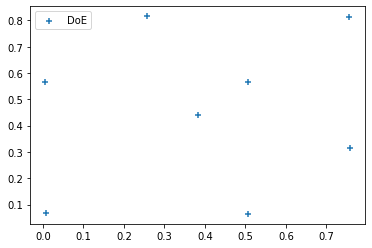

In [5]:
from matplotlib import pyplot;


pyplot.scatter(initial_query_points[:,0], initial_query_points[:,1], label="DoE", marker="+");
pyplot.legend();
pyplot.show();

# GP model construction

In [6]:
from trieste.models.gpflow import build_gpr
from trieste.models.gpflow import GaussianProcessRegression

gpflow_model = build_gpr(initial_data, search_space, likelihood_variance=1e-7)
model = GaussianProcessRegression(gpflow_model, num_kernel_samples=100)

2022-05-12 12:53:12.373040: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


# Optimization 

In [7]:
bo = trieste.bayesian_optimizer.BayesianOptimizer(observer, search_space)

num_steps = 30
result = bo.optimize(num_steps, initial_data, model)
dataset = result.try_get_final_dataset()

2022-05-12 12:53:14.273499: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Optimization completed without errors


# Post-processing of results

In [8]:
query_points = dataset.query_points.numpy()
observations = dataset.observations.numpy()

arg_min_idx = tf.squeeze(tf.argmin(observations, axis=0))

print(f"query point: {query_points[arg_min_idx, :]}")
print(f"observation: {observations[arg_min_idx, :]}")

query point: [0.54291472 0.15203905]
observation: [-1.04739246]


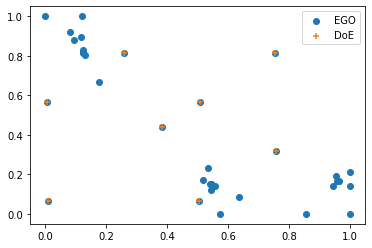

In [9]:
pyplot.scatter(query_points[:,0], query_points[:,1], label="EGO", marker="o");
pyplot.scatter(initial_query_points[:,0], initial_query_points[:,1], label="DoE", marker="+");
pyplot.legend();
pyplot.show();

In [13]:
pyplot.plot(observations[:], label="observations", marker="+");
pyplot.xlabel("evaluation number");
pyplot.ylabel("cost function");
pyplot.legend();
pyplot.show();